In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import iv
from scipy.ndimage import map_coordinates
from scipy.interpolate import RegularGridInterpolator

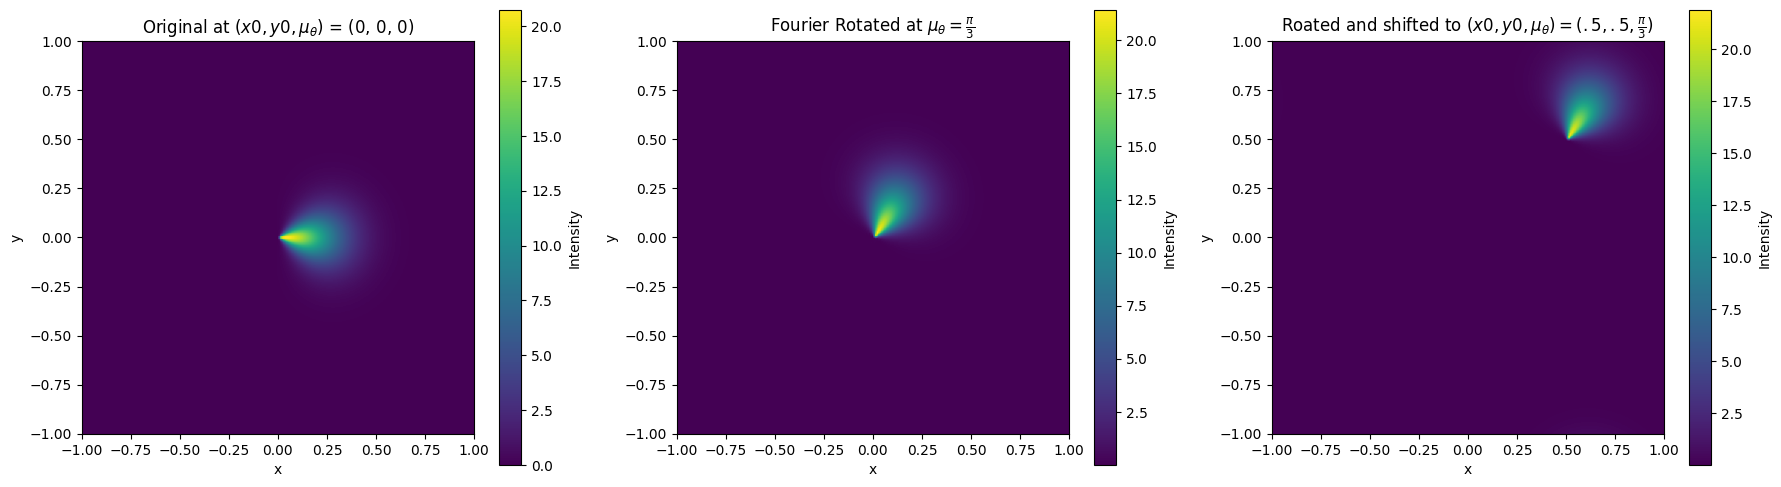

Max difference between rotated FFT and direct FFT: 107.86036853153747


In [2]:
# Distribution function with boundary zeroing
def distribution(x, y, x0, y0, mu_theta, sigma=0.2, kappa=5.0):
    gaussian = np.exp(-((x - x0)**2 + (y - y0)**2) / (2 * sigma**2))
    theta = np.arctan2(y - y0, x - x0)
    angular = np.exp(kappa * np.cos(theta - mu_theta))
    norm = 1 / (2 * np.pi * iv(0, kappa) * sigma**2)
    dist = gaussian * norm * angular
    return dist

# Create original spatial grid (256x256 over [-2, 2])
N_orig = 256
x_orig = np.linspace(-1, 1, N_orig)
y_orig = np.linspace(-1, 1, N_orig)
X_orig, Y_orig = np.meshgrid(x_orig, y_orig)

# Parameters
sigma = 0.2
kappa = 5.0
boundary_radius = 1.8
x0 = 0.0
y0 = 0.0
mu_theta = 0.0  # Initial value, will rotate to pi/3 in Fourier domain

# Original distribution at (x0, y0, mu_theta)
Z_original = distribution(X_orig, Y_orig, x0, y0, mu_theta, sigma, kappa)

# Zero-pad to 512x512 over [-4, 4] for FFT computation
N = 256
x = np.linspace(-1* N / N_orig, 1* N / N_orig, N)
y = np.linspace(-1* N / N_orig, 1* N / N_orig, N)
X, Y = np.meshgrid(x, y)
dx = x[1] - x[0]
dy = y[1] - y[0]

# Create padded distribution
Z_padded = np.zeros((N, N))
idx_start = (N - N_orig) // 2
idx_end = idx_start + N_orig
Z_padded[idx_start:idx_end, idx_start:idx_end] = Z_original
# Apply fftshift to real-space image
Z_shifted = np.fft.fftshift(Z_padded)

# Compute FFT with orthonormal normalization (divide by N)
F = np.fft.fft2(Z_shifted, norm='ortho')
F = np.fft.fftshift(F)  # Shift DC to center
freq_x = np.fft.fftshift(np.fft.fftfreq(N, dx))
freq_y = np.fft.fftshift(np.fft.fftfreq(N, dy))
Wx, Wy = np.meshgrid(freq_x, freq_y)

# Rotation by mu_theta = pi/3 (counterclockwise)
mu_theta_new = np.pi / 3
cos_alpha = np.cos(-mu_theta_new)
sin_alpha = np.sin(-mu_theta_new)
Wx_rot = Wx * cos_alpha - Wy * sin_alpha
Wy_rot = Wx * sin_alpha + Wy * cos_alpha
# Convert rotated frequencies to indices
freq_x_idx = np.arange(N)
freq_y_idx = np.arange(N)
Freq_x_idx, Freq_y_idx = np.meshgrid(freq_x_idx, freq_y_idx)
freq_x_map = (Wx_rot - freq_x[0]) / (freq_x[1] - freq_x[0])
freq_y_map = (Wy_rot - freq_y[0]) / (freq_y[1] - freq_y[0])

# Interpolate using spline (order=5)
F_real = np.real(F)
F_imag = np.imag(F)
coords = np.array([freq_y_map, freq_x_map])
F_rotated_real = map_coordinates(F_real, coords, order=5, mode='constant', cval=0)
F_rotated_imag = map_coordinates(F_imag, coords, order=5, mode='constant', cval=0)
F_rotated = F_rotated_real + 1j * F_rotated_imag

# Apply ifftshift to rotated Fourier transform
F_rotated = np.fft.ifftshift(F_rotated)

### shift it 
x0, y0 = .5, .5  # example shifts
kx = np.fft.fftfreq(N, d=dx)
ky = np.fft.fftfreq(N, d=dy)
kx_grid, ky_grid = np.meshgrid(kx, ky, indexing='ij')
shift_factor = np.exp(-2j * np.pi * (kx_grid * x0 + ky_grid * y0))
F_rotated_shifted = F_rotated * shift_factor


# Compute inverse FFT with orthonormal normalization (multiply by N)
Z_rotated_padded = np.fft.ifft2(F_rotated, norm = 'ortho')
Z_rotated_padded = np.abs(Z_rotated_padded)

# Apply ifftshift to spatial domain
Z_rotated = np.fft.ifftshift(Z_rotated_padded)

# Extract the central 256x256 region for plotting
Z_rotated = Z_rotated[idx_start:idx_end, idx_start:idx_end]

Z_rotated_shifted_padded = np.fft.ifft2(F_rotated_shifted, norm = 'ortho')
Z_rotated_shifted_padded = np.abs(Z_rotated_shifted_padded)

# Apply ifftshift to spatial domain
Z_rotated_shifted = np.fft.ifftshift(Z_rotated_shifted_padded)

# Extract the central 256x256 region for plotting
Z_rotated_shifted = Z_rotated_shifted[idx_start:idx_end, idx_start:idx_end]

# Direct computation for comparison
Z_direct = distribution(X_orig, Y_orig, 0.5, 0.5, mu_theta_new, sigma, kappa)

# Plotting
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))

im1 = ax1.imshow(Z_original, extent=[-1, 1, -1, 1], origin='lower', cmap='viridis')
ax1.set_title(r'Original at $(x0, y0, \mu_\theta)$ = (0, 0, 0)')
ax1.set_xlabel('x')
ax1.set_ylabel('y')
plt.colorbar(im1, ax=ax1, label='Intensity')

im2 = ax2.imshow(Z_rotated, extent=[-1, 1, -1, 1], origin='lower', cmap='viridis')
ax2.set_title(r'Fourier Rotated at $\mu_\theta = \frac{\pi}{3}$')
ax2.set_xlabel('x')
ax2.set_ylabel('y')
plt.colorbar(im2, ax=ax2, label='Intensity')

im3 = ax3.imshow(Z_rotated_shifted, extent=[-1, 1, -1, 1], origin='lower', cmap='viridis')
ax3.set_title(r'Roated and shifted to $(x0, y0, \mu_\theta) = (.5,.5,\frac{\pi}{3})$')
ax3.set_xlabel('x')
ax3.set_ylabel('y')
plt.colorbar(im3, ax=ax3, label='Intensity')

plt.tight_layout()
plt.show()
# Check difference between rotated FFT and direct FFT for Z_direct
Z_direct = distribution(X_orig, Y_orig, 0.5, 0.5, 0, sigma, kappa)
Z_padded = np.zeros((N, N))
Z_padded[idx_start:idx_end, idx_start:idx_end] = Z_direct
Z_shifted = np.fft.fftshift(Z_padded)
F_direct = np.fft.fft2(Z_shifted, norm='ortho')
max_diff = np.max(np.abs(F_direct - F_rotated))
print(f"Max difference between rotated FFT and direct FFT: {max_diff}")
